## Policy Gradient REINFORCE Algorithm for CartPole-v1
_Reference: based on Practical RL course by YSDA_

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


Количество действий: 2
Размерность состояния: (4,)


C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


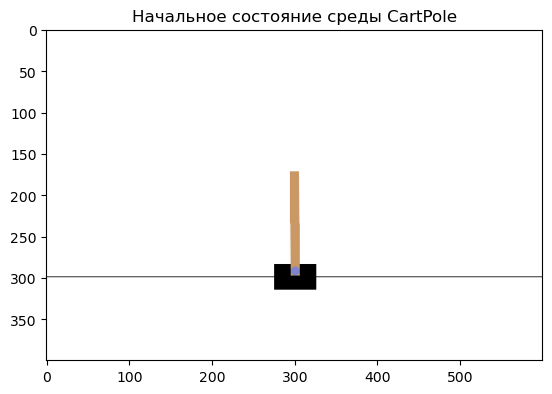

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print(f"Количество действий: {n_actions}")
print(f"Размерность состояния: {state_dim}")

plt.title("Начальное состояние среды CartPole")
plt.imshow(env.render())

# Архитектура Policy Gradient (REINFORCE)

Для алгоритма REINFORCE нам потребуется модель, которая предсказывает вероятности действий в зависимости от состояния.
Для обеспечения численной стабильности не используем softmax. Вынесем его отдельно, если понадобится.

In [4]:
class PolicyNetwork(nn.Module):
    """
    Нейронная сеть для политики агента.
    Возвращает логиты для каждого действия.
    """
    
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

In [5]:
model = PolicyNetwork(state_dim[0], n_actions).to(device)
print(model)

PolicyNetwork(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


#### Функция предсказания вероятностей действий

**Примечание:** возвращаемое значение этой функции — не torch-тензор, а numpy-массив.

Поэтому вычисление градиентов здесь не требуется.

Используйте no_grad, чтобы отключить вычисление градиентов.

Также вместо этого можно использовать .detach(), но между ними есть разница:

При использовании .detach() вычислительный граф строится, но затем отсоединяется от конкретного тензора. Поэтому .detach() следует применять в тех случаях, когда этот граф всё ещё нужен для обратного распространения градиента через другой (не отсоединённый) тензор.

В отличие от этого, в контексте no_grad() вычислительный граф вообще не строится ни для одной операции, поэтому в данном случае предпочтительнее использовать именно его.

Градиенты здесь не нужны, потому что:
- это используется только для взаимодействия со средой
- обучение будет позже

In [6]:
def predict_probs(states, model):
    """
    Предсказывает вероятности действий для заданных состояний.
    Args:
        states: numpy array of shape [batch, state_shape]
        model: torch model
    Returns:
        numpy array of shape [batch, n_actions]
    """

    with torch.no_grad():
        states = torch.from_numpy(states).float().to(device)
        logits = model(states)
        # Применяем softmax для получения вероятностей
        probs = nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

### Генерация эпизода

In [7]:
def generate_episode(env, policy_model, t_max=1000):
    """
    Генерирует один эпизод взаимодействия агента со средой.
    
    Args:
        env: среда Gymnasium
        policy_model: модель политики
        max_steps: максимальное количество шагов
        
    Returns:
        states: список состояний
        actions: список действий
        rewards: список наград
    """
    states, actions, rewards = [], [], []

    # Сбрасываем среду
    s, info = env.reset()

    for t in range(t_max):
        # Получаем вероятности действий для текущего состояния / pi(a|s)
        action_probs = predict_probs(np.array([s]), policy_model)[0]

        # Выбираем действие согласно политике
        a = np.random.choice(n_actions, p=action_probs)

        # Выполняем действие в среде
        new_s, r, done, truncated, info = env.step(a)

        # Сохраняем переход
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [8]:
# тестовый запуск
states, actions, rewards = generate_episode(env, model)
print(states, actions, rewards)

[array([1.8804947e-02, 9.7163160e-05, 4.9638715e-02, 2.7332902e-03],
      dtype=float32), array([ 0.01880689,  0.19447337,  0.04969338, -0.27388412], dtype=float32), array([ 0.02269636, -0.00132109,  0.0442157 ,  0.03404889], dtype=float32), array([ 0.02266994, -0.1970483 ,  0.04489668,  0.34034795], dtype=float32), array([ 0.01872897, -0.39277935,  0.05170364,  0.64684385], dtype=float32), array([ 0.01087338, -0.19841447,  0.06464051,  0.37088025], dtype=float32), array([ 0.00690509, -0.39439237,  0.07205812,  0.68322426], dtype=float32), array([-0.00098276, -0.20034109,  0.0857226 ,  0.4140694 ], dtype=float32), array([-0.00498958, -0.39656684,  0.09400399,  0.7324988 ], dtype=float32), array([-0.01292091, -0.59285337,  0.10865397,  1.0532252 ], dtype=float32), array([-0.02477798, -0.789235  ,  0.12971847,  1.377942  ], dtype=float32), array([-0.04056268, -0.9857163 ,  0.1572773 ,  1.7082181 ], dtype=float32), array([-0.06027701, -1.1822581 ,  0.19144167,  2.0454412 ], dtype=float32

### Вычисление дисконтированных наград

Чтобы работать с последовательными средами, нам необходимо знать накопленную дисконтированную награду для каждого состояния.
Чтобы её вычислить, можно двигаться в обратном порядке — от конца эпизода к его началу — и считать дисконтированную накопленную награду следующим образом:

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [9]:
def get_cumulative_rewards(rewards, gamma=0.99):
    """
    Вычисляет дисконтированные совокупные награды (returns) для каждого шага.

    Args:
        rewards: список наград [r_0, r_1, ..., r_T]
        gamma: коэффициент дисконтирования
        
    Returns:
        cumulative_rewards: список дисконтированных наград
    """
    
    cumulative_rewards = []
    g = 0

    # Идем с конца эпизода к началу
    for r in rewards[::-1]:
        g = g * gamma + r
        cumulative_rewards.append(g)

    cumulative_rewards.reverse()

    return cumulative_rewards

### Функция потерь для REINFORCE

Теперь нам нужно определить целевую функцию и правило обновления параметров с помощью градиента политики.

Наша целевая функция имеет вид:

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

Алгоритм REINFORCE задаёт способ вычисления градиента ожидаемой награды по параметрам политики. Формула выглядит следующим образом:
$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

Мы можем воспользоваться возможностями автоматического дифференцирования в PyTorch, определив целевую функцию в следующем виде:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

При вычислении градиента этой функции по весам сети $\theta$ мы в точности получим градиент политики.

Итоговая функция потерь также должна включать энтропийную регуляризацию $H(\pi_\theta (a_i \mid s_i))$ , чтобы стимулировать исследование (exploration):

$$
L = -\hat J(\theta) - \lambda H(\pi_\theta (a_i \mid s_i)),
$$
где $\lambda$ это коэффициент энтропийной регуляризации entropy_coef.

In [10]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1).to(device)
    return y_one_hot

In [11]:
def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Вычисляет функцию потерь для алгоритма REINFORCE.
    
    Loss = -E[log π(a|s) * G] - β * H(π)
    где H(π) — энтропия политики (для исследования)
    
    Args:
        logits: выход нейронной сети [batch, n_actions]
        actions: выбранные действия [batch]
        rewards: дисконтированные награды [batch]
        entropy_coef: коэффициент энтропии
        
    Returns:
        loss: значение функции потерь
    """
    actions = torch.tensor(actions, dtype=torch.int32).to(device)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32).to(device)

    # Вычисляем вероятности и логарифмы вероятностей
    probs = nn.functional.softmax(logits, dim=1)
    log_probs = nn.functional.log_softmax(logits, dim=1)

    # Логарифмы вероятностей для выбранных действий
    log_probs_for_actions = torch.sum(log_probs * to_one_hot(actions, n_actions), dim=1)

    # Основная часть loss: log π(a|s) * G
    J_hat = torch.mean(log_probs_for_actions * cumulative_returns)
    
    # Энтропия для исследования: -Σ p * log p
    entropy = -torch.sum(probs * log_probs, dim=1).mean()

    # Итоговый loss
    loss = -J_hat - entropy_coef * entropy

    return loss

### Обучение модели

In [12]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Обучает агента на одном эпизоде (session), сгенерированном текущей политикой.
    Функция:
    1) вычисляет логиты политики для всех состояний эпизода,
    2) считает функцию потерь по формуле REINFORCE,
    3) делает шаг градиентного спуска,
    4) возвращает суммарную награду эпизода (для логирования).
    
    Args:
    - states  — список состояний, посещённых агентом в эпизоде
    - actions — список действий, выбранных агентом в этих состояниях
    - rewards — список наград, полученных агентом на каждом шаге
    - gamma — коэффициент дисконтирования будущих наград
    - entropy_coef — коэффициент энтропийной регуляризации (стимулирует exploration)
    """

    states = torch.tensor(states, dtype=torch.float32).to(device)
    
    # Прогоняем все состояния через модель политики
    # На выходе получаем логиты действий для каждого состояния
    # shape: [T, n_actions]
    logits = model(states)
    
    # Вычисляем функцию потерь REINFORCE
    # Внутри:
    # - считается cumulative return G_t
    # - выбираются log π(a_t | s_t)
    # - добавляется энтропийная регуляризация
    loss = get_loss(logits, actions, rewards, n_actions=n_actions, gamma=gamma, entropy_coef=entropy_coef)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Возвращаем суммарную награду за эпизод
    # Используется только для мониторинга обучения
    return np.sum(rewards)

In [13]:
for i in range(500):
    rewards = [train_on_session(*generate_episode(env, model), entropy_coef=1e-3) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 800:
        print("You Win!")  # but you can train even further
        break

C:\Users\Shurik\AppData\Local\Temp\ipykernel_21560\3271327488.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


mean reward:37.950
mean reward:58.090
mean reward:84.030
mean reward:155.740
mean reward:250.800
mean reward:71.700
mean reward:199.100
mean reward:217.220
mean reward:118.270
mean reward:328.080
mean reward:211.340
mean reward:215.840
mean reward:167.020
mean reward:127.190
mean reward:153.310
mean reward:152.120
mean reward:46.450
mean reward:48.550
mean reward:104.430
mean reward:120.680
mean reward:170.310
mean reward:128.190
mean reward:105.160
mean reward:95.430
mean reward:85.740
mean reward:57.980
mean reward:33.220
mean reward:132.380
mean reward:188.680
mean reward:155.330
mean reward:171.500
mean reward:197.480
mean reward:736.960
mean reward:307.760
mean reward:141.530
mean reward:109.230
mean reward:94.270
mean reward:29.870
mean reward:100.290
mean reward:86.500
mean reward:157.150
mean reward:171.120
mean reward:235.600
mean reward:249.580
mean reward:682.730
mean reward:1000.000
You Win!


### Визуализация результатов обучения:

In [19]:
import os
import numpy as np
import gymnasium as gym
from gymnasium.utils.save_video import save_video

env_for_video = gym.make("CartPole-v1", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

obs, info = env_for_video.reset()

for step_index in range(800):
    probs = predict_probs(np.array([obs]), model)[0]
    action = np.random.choice(n_actions, p=probs)

    obs, reward, terminated, truncated, info = env_for_video.step(action)
    done = terminated or truncated

    if done or step_index == 799:
        frames = env_for_video.render()
        os.makedirs("videos", exist_ok=True)
        save_video(
            frames, "videos",
            fps=env_for_video.metadata.get("render_fps", 30),
            step_starting_index=step_starting_index,
            episode_index=episode_index,
        )
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()


        save_video(...)
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()

env_for_video.close()


TypeError: save_video() missing 1 required positional argument: 'video_folder'

Congratulations! Finally, copy the `predict_probs`, `get_cumulative_rewards` and `get_loss` to the template and submit them to the Contest.

Good luck!